In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os 
from PIL import Image
import time
import json

In [2]:
df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
with open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    data_dict = json.load(f)
    
data_dict

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [4]:
df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

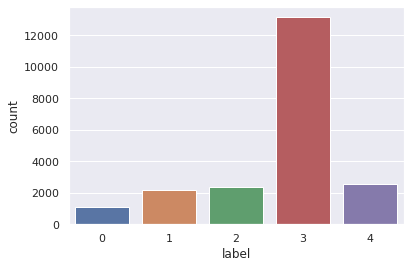

In [5]:
sns.countplot(df['label']);

In [6]:
train_path = '../input/cassava-leaf-disease-classification/train_images/'

In [7]:
samples = df['image_id'].sample(10).values
for i in range(10):
    print(plt.imread(train_path + samples[i]).shape)

(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)
(600, 800, 3)


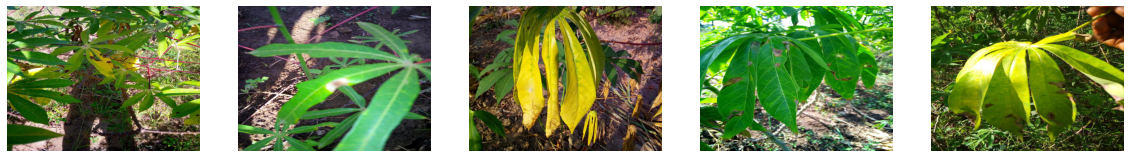

In [8]:
samples_0 = df[df['label'] == 0]['image_id'].values

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(plt.imread(train_path + samples_0[i]))
    ax[i].axis('off')

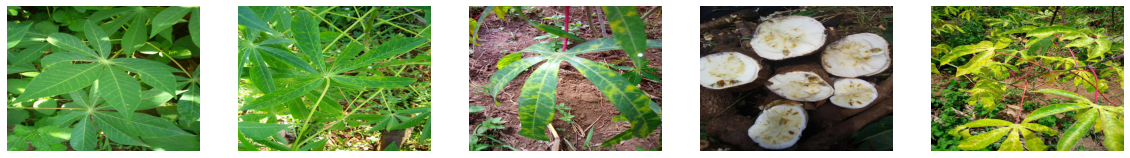

In [9]:
samples_1 = df[df['label'] == 1]['image_id'].values

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(plt.imread(train_path + samples_1[i]))
    ax[i].axis('off')

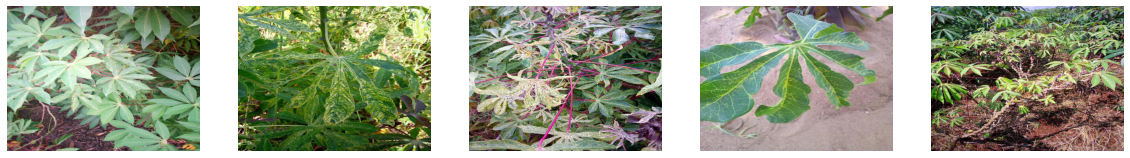

In [10]:
samples_2 = df[df['label'] == 2]['image_id'].values

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(plt.imread(train_path + samples_2[i]))
    ax[i].axis('off')

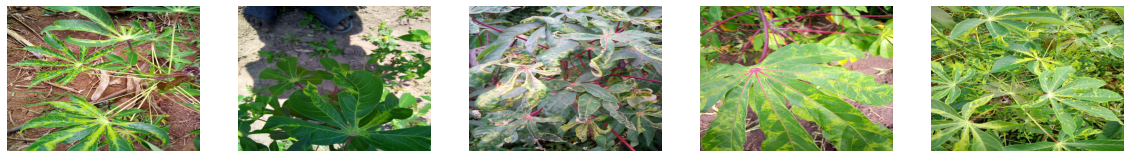

In [11]:
samples_3 = df[df['label'] == 3]['image_id'].values

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(plt.imread(train_path + samples_3[i]))
    ax[i].axis('off')

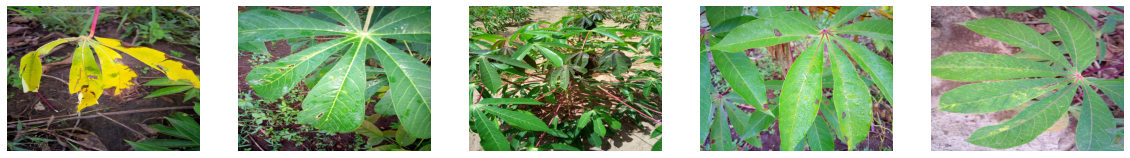

In [12]:
samples_4 = df[df['label'] == 4]['image_id'].values

fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(plt.imread(train_path + samples_4[i]))
    ax[i].axis('off')

# Load and preprocess data

In [13]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision import models

In [14]:
torch.cuda.is_available()

True

In [15]:
device = torch.device('cuda')

In [16]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [17]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [18]:
class CassavaDataset(Dataset):
    def __init__(self, df, image_folder, train=True, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform
        self.train = train
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, index):
        img_path = os.path.join(self.image_folder, self.df.iloc[index]['image_id'])
        image = Image.open(img_path)
        #image = cv2.imread(img_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        if self.train:
            label = self.df.iloc[index]['label']
            return image, label
            
        return image

In [19]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [20]:
train_transform = transforms.Compose([
    #transforms.Resize(512),
    #transforms.CenterCrop(512),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    #transforms.Resize(512),
    #transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [21]:
train_data = CassavaDataset(train, train_path, train=True, transform=train_transform)
validation_data = CassavaDataset(test, train_path, train=True, transform=test_transform)

In [22]:
train_dl = DataLoader(train_data, batch_size=10, shuffle=True, pin_memory=True)
valid_dl = DataLoader(validation_data, batch_size=10, shuffle=False, pin_memory=True)

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Training part

## CNN

# Creating model
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn1 = nn.Conv2d(3, 64, 3, 1)
        self.cnn2 = nn.Conv2d(64, 128, 3, 1)
        self.cnn3 = nn.Conv2d(128, 256, 3, 1)
        self.cnn4 = nn.Conv2d(256, 512, 3, 1)
        self.fc1 = nn.Linear(12*12*512, 6182)
        self.fc2 = nn.Linear(6182, 512)
        self.fc4 = nn.Linear(512, 5)
        
        self.drop = nn.Dropout(0.5)
        self.cnndrop = nn.Dropout2d(0.5)
        
        
    def forward(self, X):
        X = F.relu(self.cnn1(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = F.relu(self.cnn2(X))
        X = F.max_pool2d(X, 2, 2)
        
        X = F.relu(self.cnn3(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.cnndrop(X)
        
        X = F.relu(self.cnn4(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.cnndrop(X)
        
        X = X.view(-1, 12*12*512)
        
        X = F.relu(self.fc1(X))
        X = self.drop(X)
        
        X = F.relu(self.fc2(X))
        out = self.fc4(X)
        
        return F.log_softmax(out, dim=1)        

In [24]:
cnn_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0),
    #nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
    #nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), 
    #nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.5),
    
    nn.Flatten(),
    
    nn.Linear(35*48*256, 128), 
    nn.ReLU(),
    nn.Dropout(0.5),
    #nn.Linear(1024, 128),
    #nn.ReLU(),
    nn.Linear(128, 5),
    nn.LogSoftmax(dim=1)
)

In [25]:
def training_loop(epochs, model, optimizer):
    
    criterion = nn.CrossEntropyLoss()
    
    train_losses, test_losses = [], []
    train_metrics, test_metrics = [], []

    for epoch in range(epochs):
        tr_corr = 0
        ts_corr = 0

        start_time = time.time()

        for X_train, y_train in train_dl:   
            y_pred = model(X_train)
            train_loss = criterion(y_pred, y_train)
            #train_acc = accuracy(y_pred, y_train)
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            tr_corr += batch_corr

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()


        train_losses.append(train_loss)
        train_metrics.append(tr_corr)

        with torch.no_grad():
            for X_test, y_test in valid_dl:
                y_val = model(X_test)
                #val_acc = accuracy(y_val, y_test)
                predicted = torch.max(y_val.data, 1)[1]
                batch_corr = (predicted == y_test).sum()
                ts_corr += batch_corr

        val_loss = criterion(y_val, y_test)            
        test_losses.append(val_loss)
        test_metrics.append(ts_corr)

        end_time = time.time() - start_time
        print('Epoch [{}/{}], train_loss {:.4f}, val_loss {:.4f}, train_acc {:.4f}, val_acc {:.4f}, time: {:.4f}'
              .format(epoch+1, epochs, train_loss, val_loss, tr_corr.item()/len(train), ts_corr.item()/len(test), end_time/60))
    
    return train_losses, test_losses, train_metrics, test_metrics
    

In [26]:
epochs = 10

model = cnn_model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [27]:
tr_losses, ts_losses, tr_acc, ts_acc = training_loop(epochs, model, optimizer) 

Epoch [1/10], train_loss 0.8712, val_loss 1.0433, train_acc 0.6148, val_acc 0.6327, time: 8.4957
Epoch [2/10], train_loss 1.0933, val_loss 0.9433, train_acc 0.6265, val_acc 0.6437, time: 6.9640
Epoch [3/10], train_loss 1.6040, val_loss 1.0699, train_acc 0.6332, val_acc 0.6505, time: 6.9252
Epoch [4/10], train_loss 1.4768, val_loss 0.8131, train_acc 0.6412, val_acc 0.6544, time: 6.9275
Epoch [5/10], train_loss 0.6524, val_loss 0.9780, train_acc 0.6534, val_acc 0.6631, time: 6.9656
Epoch [6/10], train_loss 1.0253, val_loss 0.9745, train_acc 0.6593, val_acc 0.6727, time: 6.9349
Epoch [7/10], train_loss 0.9930, val_loss 1.1678, train_acc 0.6640, val_acc 0.6736, time: 6.9771
Epoch [8/10], train_loss 0.8719, val_loss 1.4494, train_acc 0.6721, val_acc 0.6790, time: 6.9886
Epoch [9/10], train_loss 0.6779, val_loss 1.5559, train_acc 0.6818, val_acc 0.6879, time: 6.9312
Epoch [10/10], train_loss 0.7393, val_loss 1.4497, train_acc 0.6794, val_acc 0.6867, time: 6.9200


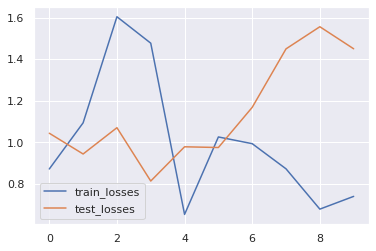

In [28]:
plt.plot(range(epochs), [loss.item() for loss in tr_losses], label='train_losses')
plt.plot(range(epochs), [loss.item() for loss in ts_losses], label='test_losses')
plt.legend();

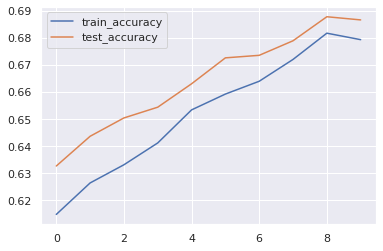

In [29]:
plt.plot(range(epochs), [acc.item()/len(train) for acc in tr_acc], label='train_accuracy')
plt.plot(range(epochs), [acc.item()/len(test) for acc in ts_acc], label='test_accuracy')
plt.legend();

## RestNet50

In [30]:
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [31]:
for param in resnet.parameters():
    param.requires_grad = False

for i, param in enumerate(resnet.parameters()):
    if i > 50:
        param.requires_grad = True

In [32]:
resnet.fc = nn.Sequential(
    nn.Linear(2048, 512), nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5),
    nn.LogSoftmax(dim=1))

In [33]:
resnet_model = resnet.cuda()
epochs = 8
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0001)

In [34]:
tr_losses, ts_losses, tr_acc, ts_acc = training_loop(epochs, resnet_model, optimizer) 

Epoch [1/8], train_loss 0.7390, val_loss 1.1886, train_acc 0.8025, val_acc 0.8332, time: 14.5897
Epoch [2/8], train_loss 0.2359, val_loss 0.5890, train_acc 0.8496, val_acc 0.8505, time: 14.5821
Epoch [3/8], train_loss 0.5533, val_loss 1.0415, train_acc 0.8595, val_acc 0.8636, time: 14.5909
Epoch [4/8], train_loss 0.0635, val_loss 0.6888, train_acc 0.8680, val_acc 0.8687, time: 14.6458
Epoch [5/8], train_loss 0.0446, val_loss 0.9706, train_acc 0.8707, val_acc 0.8572, time: 14.6841
Epoch [6/8], train_loss 0.4345, val_loss 0.4586, train_acc 0.8768, val_acc 0.8706, time: 14.6475
Epoch [7/8], train_loss 0.4830, val_loss 0.4776, train_acc 0.8800, val_acc 0.8745, time: 14.6601
Epoch [8/8], train_loss 0.0261, val_loss 0.5656, train_acc 0.8828, val_acc 0.8713, time: 14.6479


In [35]:
#torch.save(resnet_model, 'resnet_model.pt')

## ResNext

In [36]:
resnext = models.resnext50_32x4d(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [37]:
for param in resnext.parameters():
    param.requires_grad = False

for i, param in enumerate(resnext.parameters()):
    if i > 50:
        param.requires_grad = True

In [38]:
resnext.fc = nn.Sequential(     
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5),
    nn.LogSoftmax(dim=1)) 

In [39]:
resnext_model = resnext.cuda()
epochs = 8
optimizer = torch.optim.Adam(resnext_model.parameters(), lr=0.0001)

In [40]:
tr_losses, ts_losses, tr_acc, ts_acc = training_loop(epochs, resnext_model, optimizer)

Epoch [1/8], train_loss 0.0404, val_loss 0.6740, train_acc 0.8180, val_acc 0.8414, time: 19.8403
Epoch [2/8], train_loss 1.8858, val_loss 0.4527, train_acc 0.8544, val_acc 0.8593, time: 19.8278
Epoch [3/8], train_loss 1.7418, val_loss 0.6402, train_acc 0.8680, val_acc 0.8629, time: 19.8548
Epoch [4/8], train_loss 0.2274, val_loss 0.5602, train_acc 0.8765, val_acc 0.8617, time: 19.8820
Epoch [5/8], train_loss 0.0410, val_loss 1.1879, train_acc 0.8809, val_acc 0.8801, time: 19.9215
Epoch [6/8], train_loss 0.5614, val_loss 0.8987, train_acc 0.8858, val_acc 0.8734, time: 19.8448
Epoch [7/8], train_loss 0.2553, val_loss 0.5280, train_acc 0.8912, val_acc 0.8790, time: 19.8787
Epoch [8/8], train_loss 0.6835, val_loss 0.7633, train_acc 0.8955, val_acc 0.8818, time: 19.9056


In [41]:
torch.save(resnext_model, 'resnext_model.pt')

## EfficientNet

In [42]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=ce29a2ebf3375de8d7bdc7a7bff56b1c99046da5ef2cabbc990d3458f7987f6f
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [43]:
from efficientnet_pytorch import EfficientNet
efficient_net = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [44]:
for param in efficient_net.parameters():
    param.requires_grad = False

for i, param in enumerate(efficient_net.parameters()):
    if i > 60:
        param.requires_grad = True

In [45]:
efficient_net._fc = nn.Sequential(     
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 5))

In [46]:
effnet_model = efficient_net.cuda()
epochs = 10
optimizer = torch.optim.Adam(effnet_model.parameters(), lr=0.0001)

In [47]:
tr_losses, ts_losses, tr_acc, ts_acc = training_loop(epochs, effnet_model, optimizer)

Epoch [1/10], train_loss 0.5950, val_loss 0.7516, train_acc 0.8070, val_acc 0.8537, time: 13.4725
Epoch [2/10], train_loss 0.1179, val_loss 0.5484, train_acc 0.8621, val_acc 0.8603, time: 13.4839
Epoch [3/10], train_loss 0.4142, val_loss 0.5075, train_acc 0.8751, val_acc 0.8722, time: 13.4954
Epoch [4/10], train_loss 0.5186, val_loss 0.5676, train_acc 0.8870, val_acc 0.8748, time: 13.5079
Epoch [5/10], train_loss 0.0997, val_loss 0.6299, train_acc 0.8987, val_acc 0.8678, time: 13.4639
Epoch [6/10], train_loss 0.0375, val_loss 0.8229, train_acc 0.9040, val_acc 0.8745, time: 13.4433
Epoch [7/10], train_loss 1.3529, val_loss 0.4749, train_acc 0.9119, val_acc 0.8748, time: 13.3951
Epoch [8/10], train_loss 0.1803, val_loss 1.1170, train_acc 0.9183, val_acc 0.8748, time: 13.4523
Epoch [9/10], train_loss 0.0550, val_loss 0.8199, train_acc 0.9248, val_acc 0.8715, time: 13.4231
Epoch [10/10], train_loss 0.3010, val_loss 0.6531, train_acc 0.9302, val_acc 0.8664, time: 13.4620


# Test part

In [48]:
test_path = '../input/cassava-leaf-disease-classification/test_images/'

In [49]:
test_df = pd.DataFrame(columns=['image_id'], data=os.listdir(test_path))

In [50]:
test_images = CassavaDataset(test_df, test_path, train=False, transform=test_transform)
test_images_dl = DataLoader(test_images, batch_size=10)
test_images_dl = DeviceDataLoader(test_images_dl, device)

In [51]:
test_labels = []

resnet_model.eval()

for test_image in test_images_dl:
    preds = resnet_model(test_image)
    y_test = torch.max(preds, 1)[1]
    
    test_labels.append(y_test.view(-1).item())

In [52]:
test_df['label'] = test_labels

In [53]:
test_df.to_csv('submission.csv', index=False)